In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/CAMELYON17/training/center_0/patient_000.zip"
with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('finish')

In [0]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1MB 26kB/s 
     |████████████████████████████████| 8.8MB 1.9MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
pip install "pillow<7"

     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
! git clone https://github.com/basveeling/pcam.git

Cloning into 'pcam'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 44 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (44/44), done.


In [0]:
import tensorflow_datasets as tfds
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteQ7NSZJ/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteQ7NSZJ/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteQ7NSZJ/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
     

In [0]:
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0   

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [0]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=5, steps_per_epoch=4096, validation_steps=256)

Epoch 1/5
4096/4096 - 384s - loss: 0.4514 - accuracy: 0.7935 - val_loss: 0.4760 - val_accuracy: 0.7885
Epoch 2/5
4096/4096 - 384s - loss: 0.3249 - accuracy: 0.8626 - val_loss: 0.3454 - val_accuracy: 0.8520
Epoch 3/5
4096/4096 - 389s - loss: 0.2584 - accuracy: 0.8960 - val_loss: 0.4255 - val_accuracy: 0.8262
Epoch 4/5
4096/4096 - 386s - loss: 0.2238 - accuracy: 0.9123 - val_loss: 0.3458 - val_accuracy: 0.8517
Epoch 5/5
4096/4096 - 381s - loss: 0.2019 - accuracy: 0.9226 - val_loss: 0.3864 - val_accuracy: 0.8514


In [0]:
model.save("./patchcamelyon.hf5")

In [0]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)

print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.8212


In [0]:
!pip install --upgrade setuptools pip


     |████████████████████████████████| 583kB 2.6MB/s 
     |████████████████████████████████| 1.5MB 5.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 46.3.0
    Uninstalling setuptools-46.3.0:
      Successfully uninstalled setuptools-46.3.0
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [0]:
!pip install openslides

     |████████████████████████████████| 7.8 MB 2.3 MB/s 
     |████████████████████████████████| 399 kB 43.8 MB/s 
     |████████████████████████████████| 7.5 MB 52.4 MB/s 
     |████████████████████████████████| 911 kB 49.1 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 1.8 MB 40.6 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 582 kB 50.9 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 3.1 MB 50.2 MB/s 
     |████████████████████████████████| 52 kB 857 kB/s 
     |████████████████████████████████| 234 kB 51.4 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 2.7 MB 49.3 MB/s 
  Created wheel for openslides: filename=openslides-3.1-py3-none-any.whl size=8198112 sha256=0af2d4780c7834f51df1592c7cf8c9bbb5fad2d26477351af00eb2d27168bdfa
  Stored in directory: /root/.cache/pip/w

In [0]:
!apt update && apt install -y openslide-tools

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Fetched 88.7 kB in 2s (37.0 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information

In [0]:
!pip install openslide-python

  Using cached openslide-python-1.1.1.tar.gz (312 kB)
  Created wheel for openslide-python: filename=openslide_python-1.1.1-cp36-cp36m-linux_x86_64.whl size=27367 sha256=40303e7512c67938dc39aabd014abcdd8572de702e02a7482fd60773c41ef00e
  Stored in directory: /root/.cache/pip/wheels/9e/97/4a/781ecf32f77a927a577efcd6767be992a890c02d4b02f1f1e3
Successfully built openslide-python


In [0]:
!unzip -q "/content/drive/My Drive/CAMELYON17/testing/patients/patient_100.zip"

error:  zipfile read error


In [0]:
import openslide as os
import json
from openslide import deepzoom
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:

import openslide as os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

In [0]:
with open('/content/settings_sample.json','r') as file:
    slide = os.OpenSlide('/content/patient_100_node_1.tif')
    slide.level_dimensions



((178688, 99840),
 (89344, 49920),
 (44672, 24960),
 (22336, 12480),
 (11168, 6240),
 (5584, 3120),
 (2792, 1560),
 (1396, 780),
 (698, 390),
 (349, 195))

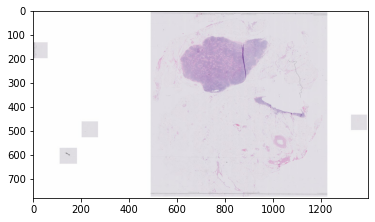

In [0]:
level = slide.level_count - 3
img = slide.read_region((0,0),level,slide.level_dimensions[level])
plt.imshow(img)
plt.show()

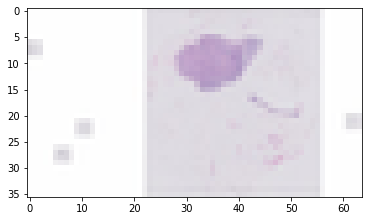

In [64]:
plt.imshow(slide.get_thumbnail((64,64)))

In [67]:
dz = deepzoom.DeepZoomGenerator(slide)
dz.level_count
dz.tile_count
dz.level_tiles

19

370048

((1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (6, 4),
 (11, 7),
 (22, 13),
 (44, 25),
 (88, 50),
 (176, 99),
 (352, 197),
 (704, 394))

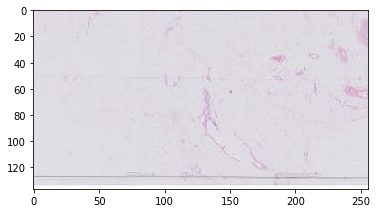

In [68]:
plt.imshow(dz.get_tile(10,(1,1)))
plt.show()

In [0]:
df_data = pd.read_csv('/content/drive/My Drive/CAMELYON17/training/stage_labels.csv')

In [101]:
print(df_data.shape)


(600, 2)


In [104]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   patient  600 non-null    object
 1   stage    600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [105]:
df_data.head()

,patient,stage
0,patient_000.zip,pN0
1,patient_000_node_0.tif,negative
2,patient_000_node_1.tif,negative
3,patient_000_node_2.tif,negative
4,patient_000_node_3.tif,negative


In [108]:
df_data['stage'].value_counts()

negative    318
macro        87
micro        59
itc          36
pN1          30
pN0          24
pN1mi        21
pN2          14
pN0(i+)      11
Name: stage, dtype: int64

In [142]:
data = pd.read_csv('/content/drive/My Drive/CAMELYON17/testing/evaluation/submission_example.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   patient  600 non-null    object
 1   stage    600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
